# Tomato algorithm

In [1]:
import numpy as np
import umap
from ripser import ripser, plot_dgms, lower_star_img
from sklearn.neighbors import KDTree
from tqdm import tqdm

## Union find data structure

In [2]:
class UnionFind:
    
    def __init__(self):
        '''\
Create an empty union find data structure.'''
        self.num_weights = {}
        self.parent_pointers = {}
        self.num_to_objects = {}
        self.objects_to_num = {}
        self.__repr__ = self.__str__
        
    def insert_objects(self, objects):
        '''\
Insert a sequence of objects into the structure.  All must be Python hashable.'''
        for object in objects:
            self.find(object);
            
    def find(self, object):
        '''\
Find the root of the set that an object is in.
If the object was not known, will make it known, and it becomes its own set.
Object must be Python hashable.'''
        if not object in self.objects_to_num:
            obj_num = len(self.objects_to_num)
            self.num_weights[obj_num] = 1
            self.objects_to_num[object] = obj_num
            self.num_to_objects[obj_num] = object
            self.parent_pointers[obj_num] = obj_num
            return object
        stk = [self.objects_to_num[object]]
        par = self.parent_pointers[stk[-1]]
        while par != stk[-1]:
            stk.append(par)
            par = self.parent_pointers[par]
        for i in stk:
            self.parent_pointers[i] = par
        return self.num_to_objects[par]
    
    def union(self, object1, object2):
        '''\
Combine the sets that contain the two objects given.
Both objects must be Python hashable.
If either or both objects are unknown, will make them known, and combine them.'''
        o1p = self.find(object1)
        o2p = self.find(object2)
        if o1p != o2p:
            on1 = self.objects_to_num[o1p]
            on2 = self.objects_to_num[o2p]
            w1 = self.num_weights[on1]
            w2 = self.num_weights[on2]
            if w1 < w2:
                o1p, o2p, on1, on2, w1, w2 = o2p, o1p, on2, on1, w2, w1
            self.num_weights[on1] = w1+w2
            del self.num_weights[on2]
            self.parent_pointers[on2] = on1
    
    def get_parents(self, num):
        

        return(self.parent_pointers[num])

## ToMATo algorithm:


**Source**:

**Steve Oudot** [*Persistence Theory: From Quiver Representations to Data Analysis.* AMS Mathematical Surveys and Monographs, volume 209, 2015](https://geometrica.saclay.inria.fr/team/Steve.Oudot/books/o-pt-fqrtda-15/surv-209.pdf)

![title](ToMATo.png)

In [127]:
class ToMATo():
    
    def __init__(self, X, tau, sigma_kde = 0.2, kernel = 'gaussian'):
        
        self.X = X
        self.n = len(X)
        self.tau = tau
        self.tree = KDTree(X)
        self.kde = self.tree.kernel_density(X, h=sigma_kde, kernel=kernel)
    
    def clustering(self, nb_neighbors):
        
        """Create the clusters. Returns:
        
        - a vector of length len(X) with the ids of the cluster containing each data point.
        - a vector containing the centroides"""
        
        # The clusters are built using a Union Find data structure
        
        clusters = UnionFind()
        
        # We sort the list of indices by decreasing order of density
        
        sorted_kde = np.argsort(self.kde)[::-1]
        
        for i in tqdm(range(self.n)):
            
            # We extract the list of indices of the k=nb_neighboors nearest neighbors of X[sorted_kde[i]]
            
            neighbors = list(self.tree.query([self.X[sorted_kde[i]]], k=nb_neighbors, return_distance=False).flatten())
            
            for j in neighbors:
                
                # If one of the neighbor extracted have a smaller value of density, we remove it
                
                if np.where([sorted_kde[k]==j for k in range(self.n)])[0][0] > i:
                    
                    neighbors.remove(j)
            
            if len(neighbors) == 0:
                
                # If no neighbors are left, we create a new cluster
                
                clusters.insert_objects(sorted_kde[i])
            
            else:
                
                # We find the pseudo gradient edge
                
                pseudo_gradient_edge = neighbors[np.argmax(np.array([self.kde[k] for k in neighbors]).flatten())]
                e_i = clusters.find(pseudo_gradient_edge)
                
                for j in neighbors:
                    
                    e = clusters.find(j)
                    
                    if e != e_i and min((self.kde[e], self.kde[e_i])) < self.kde[sorted_kde[i]] + self.tau:
                        
                        clusters.union(e, e_i)
                        e_i = clusters.find(e_i)
        
        # Fix the fact that the UnionFind data structure doesn't attribute a single parent to each cluster
        
        cpt = 0
        dict_to_return = clusters.parent_pointers.copy()
        ids = list(clusters.parent_pointers.keys())[0]
        root = clusters.parent_pointers[ids]
        ids_to_change = []
        
        while cpt < self.n -1:
            
            while ids != root:
                
                ids_to_change.append(ids)
                ids = root
                root = clusters.get_parents(ids)
            
            if ids == root:
                
                cpt += 1
                
                for num in ids_to_change:
                    
                    dict_to_return[num] = root
                    
                ids = list(clusters.parent_pointers.keys())[cpt]
                root = clusters.parent_pointers[ids]
                ids_to_change = []
        
        # translate the ids into object
        
        list_to_return = [None]*len(dict_to_return)
        
        for ids, root in dict_to_return.items():
            
            list_to_return[clusters.num_to_objects[ids]] = clusters.num_to_objects[root]
            
        list_of_centroids = []
        list_to_return = np.array(list_to_return)
        
        for ids in np.unique(list_to_return):
            
            list_of_centroids.append(self.X[ids])
            
        return(list_to_return, np.array(list_of_centroids))            

## Test sur un "toy dataset":

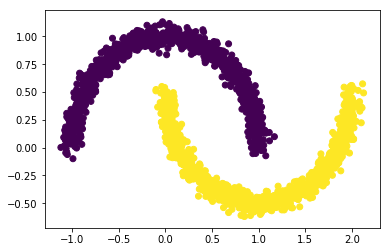

In [4]:
from sklearn import datasets
import matplotlib.pyplot as plt

noisy_circles = datasets.make_moons(n_samples=2000, noise=.05)
plt.scatter(noisy_circles[0][:,0], noisy_circles[0][:,1], c=noisy_circles[1])
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 489.47it/s]


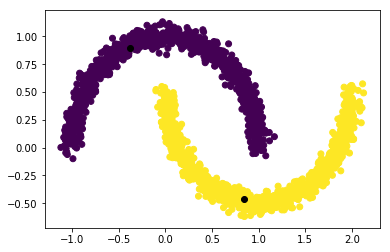

Wall time: 4.52 s


In [5]:
%%time

model = ToMATo(noisy_circles[0], 100)
y_predict, centroids = model.clustering(6)
plt.scatter(noisy_circles[0][:,0], noisy_circles[0][:,1], c=y_predict)
plt.scatter(centroids[:,0], centroids[:,1], color='k')
plt.show()

## Test pour sentiment analysis

### Charge en mémoire les textes

In [6]:
import os
import pickle

imdb_dir = 'aclImdb' # Data directory
train_dir = os.path.join(imdb_dir, 'train') # Get the path of the train set

# Setup empty lists to fill
labels = []
texts = []
# First go through the negatives, then through the positives
for label_type in ['neg', 'pos']:
    # Get the sub path
    dir_name = os.path.join(train_dir, label_type)
    print('loading ',label_type)
    # Loop over all files in path
    for fname in tqdm(os.listdir(dir_name)):
        
        # Only consider text files
        if fname[-4:] == '.txt':
            # Read the text file and put it in the list
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            # Attach the corresponding label
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
        
pickle.dump( labels, open( "/labels_imdb.p", "wb" ) )
pickle.dump( texts, open( "/texts_imdb.p", "wb" ) )                

loading  neg


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:08<00:00, 202.51it/s]


loading  pos


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:06<00:00, 187.16it/s]


### Tokenize les textes

In [7]:
from collections import Counter
import re

data = []

for k in tqdm(range(len(texts))):
    
    texts[k] = texts[k].replace('"', "'")
    data.append(re.split(" |\.|-|'|<br />|\(|\)|\!|\?|\,|\;|\:", texts[k]))
    cpt = 0
    
    for i in range(len(data[k])):
        
        data[k][i-cpt] = data[k][i-cpt].lower()
        
        if data[k][i-cpt] == '':
            
            data[k].pop(i-cpt)
            cpt += 1

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:05<00:00, 4872.03it/s]


### Crée le vocabulaire

In [8]:
words = (tokens for sent in data for tokens in sent)
voc = Counter(words)

In [13]:
len(voc)

80836

### Ne retient que les adjectifs de chaque texte

In [11]:
import spacy

nlp = spacy.load('en')
data_adj = []

for lines in tqdm(texts):
    
    doc = nlp(lines)
    adj_k = []
    
    for tokens in doc:
        
        if 'JJ' in tokens.tag_:
            
            adj_k.append(tokens.text.lower())
    
    data_adj.append(adj_k)
            

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [22:34<00:00, 18.45it/s]


In [14]:
pickle.dump(data_adj, open( "/texts_adj.p", "wb" ) )  

### Crée ensemble d'adjectifs présents dans phrases positives et négatives

In [34]:
neg_adj = (tokens for sent in data_adj[:12500] for tokens in sent)
pos_adj = (tokens for sent in data_adj[12500:] for tokens in sent)
voc_neg = Counter(neg_adj)
voc_pos = Counter(pos_adj)

### Importe les embeddings FastText

In [35]:
import io

def load_vectors(fname, voc):
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}

    for line in fin:
       
        tokens = line.rstrip().split(' ')
        
        if tokens[0] in voc:
            
            data[tokens[0]] = np.array(tokens[1:]).astype(float)
            
    return data

In [36]:
embeddings = load_vectors('cc.en.300.vec', voc)

### Crée le dataset que l'on va utiliser en prenant la moyenne des adjectifs de chaque avis

In [90]:
def create_mean_adj_dataset(data_adj, embeddings):
    
    sentiment_dataset = []
    
    for lines in data_adj:
        
        line_k = []
        
        for adj in lines:
        
            if adj in embeddings:
                
                line_k.append(embeddings[adj])
        
        if len(line_k) == 0:
            
            line_k.append(np.zeros(300))
            
        line_k_mean = np.mean(np.array(line_k), axis=0)
        sentiment_dataset.append(line_k_mean)
    
    return(np.array(sentiment_dataset))

In [91]:
data_mean = create_mean_adj_dataset(data_adj, embeddings)

### Réduction de dimension puis classification

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_mean, labels, test_size=.30, random_state=42)

In [114]:
%%time

import umap

mapper = umap.UMAP(n_components=2, random_state=42, metric='cosine').fit(X_train, y_train)

Wall time: 32.3 s


In [115]:
%%time
test_embedding = mapper.transform(X_test)

Wall time: 8.51 s


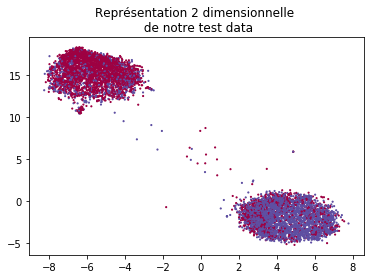

In [116]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_test, cmap='Spectral', s=1.3)
plt.title('Représentation 2 dimensionnelle \n de notre test data')
plt.show()

In [117]:
%%time
train_embedding = mapper.transform(X_train)

Wall time: 50.9 ms


In [118]:
%%time

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf_svc = SVC(gamma=2, C=1)
clf_svc.fit(train_embedding, y_train)
y_pred_svc = clf_svc.predict(test_embedding)
acc_svc = accuracy_score(y_test, y_pred_svc)
print ('SVC accuracy: ',acc_svc)

SVC accuracy:  0.7748
Wall time: 2.79 s


100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:48<00:00, 154.81it/s]


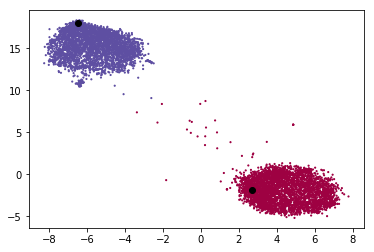

Wall time: 49.7 s


In [121]:
%%time

model = ToMATo(test_embedding, 200)
y_predict, centroids = model.clustering(6)
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_predict, cmap='Spectral', s=1.3)
plt.scatter(centroids[:,0], centroids[:,1], color='k')
plt.show()

In [9]:
def transform_output_tomato(y_pred):
    
    y_return = [0]*len(y_pred)
    dict_of_translation = dict()
    cpt = 0
    
    for ids in np.unique(y_pred):
        
        dict_of_translation[ids] = cpt
        cpt += 1
    
    for k in range(len(y_pred)):
        
        y_return[k] = dict_of_translation[y_pred[k]]
    
    return(y_return)

In [129]:
y_tomato = transform_output_tomato(y_predict)
acc_tomato = accuracy_score(y_test, 1-np.array(y_tomato))
print ('ToMATo accuracy: ',acc_tomato)

ToMATo accuracy:  0.7744


### Représentation "bag of words" de chaque texte

In [11]:
def create_dataset_bow(voc, data):
    
    dataset = []
    dict_of_translation = dict()
    cpt = 0
    voc_bis = dict()
    
    for words, counts in voc.items():
        
        if counts > 5:
            
            voc_bis[words] = counts
            
    n = len(voc_bis)
    print('number of dimensions = ', n)
    
    for words in voc_bis.keys():
        
        dict_of_translation[words] = cpt
        cpt += 1
    
    for lines in tqdm(data):
        
        data_k = [0]*n
        comptes = Counter(lines)
        
        for words, counts in comptes.items():
            
            if words in voc_bis:
            
                data_k[dict_of_translation[words]] = counts
        
        dataset.append(data_k)
    
    return(dataset)

In [12]:
data_bow = create_dataset_bow(voc, data)

number of dimensions =  26663


100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:07<00:00, 3421.17it/s]


In [14]:
%%time

from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X = pca.fit_transform(data_bow)


Wall time: 1min 17s


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=.30, random_state=42)

In [16]:
%%time

import umap

mapper = umap.UMAP(n_components=2, random_state=42, metric='cosine').fit(X_train, y_train)

Wall time: 1min 5s


In [17]:
%%time
test_embedding = mapper.transform(X_test)

Wall time: 14.3 s


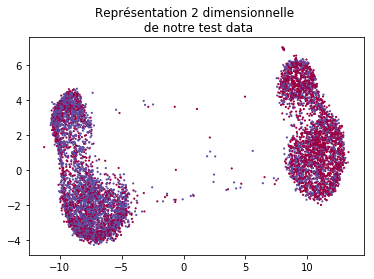

In [18]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_test, cmap='Spectral', s=1.3)
plt.title('Représentation 2 dimensionnelle \n de notre test data')
plt.show()

In [26]:
%%time
train_embedding = mapper.transform(X_train)

Wall time: 9.97 ms


In [27]:
%%time

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf_svc = SVC(gamma=2, C=1)
clf_svc.fit(train_embedding, y_train)
y_pred_svc = clf_svc.predict(test_embedding)
acc_svc = accuracy_score(y_test, y_pred_svc)
print ('SVC accuracy: ',acc_svc)

SVC accuracy:  0.6433333333333333
Wall time: 1.16 s


## Test pour CIFAR 10

In [36]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [48]:
def extract_dataset():
    
    CIFAR10_1 = unpickle('cifar-10-batches-py/data_batch_1')
    data = CIFAR10_1[b'data']
    labels = CIFAR10_1[b'labels']
    
    for k in range(4):
        
        CIFAR10_k = unpickle('cifar-10-batches-py/data_batch_' + str(k+2))
        data = np.concatenate((data, CIFAR10_k[b'data']), axis=0)
        labels = np.concatenate((labels, CIFAR10_k[b'labels']), axis=0)
    
    return(data, labels)

In [49]:
data_train, labels_train = extract_dataset()

In [52]:
CIFAR10_test = unpickle('cifar-10-batches-py/test_batch')
data_test = CIFAR10_test[b'data']
labels_test = CIFAR10_test[b'labels']

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data_train)
X_train = scaler.transform(data_train)
X_test = scaler.transform(data_test)

L:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [96]:
%%time

import umap

mapper = umap.UMAP(n_components=2, random_state=42, metric='correlation').fit(X_train, labels_train)

L:\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Wall time: 6min 16s


In [97]:
%%time
test_embedding = mapper.transform(X_test)

Wall time: 1min 14s


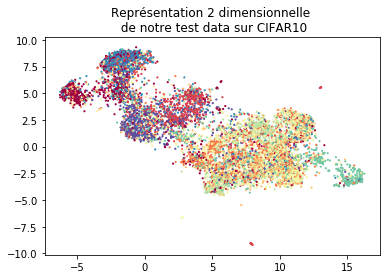

In [98]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=labels_test, cmap='Spectral', s=1.3)
plt.title('Représentation 2 dimensionnelle \n de notre test data sur CIFAR10')
plt.show()

In [99]:
%%time
train_embedding = mapper.transform(X_train)

Wall time: 1.62 s


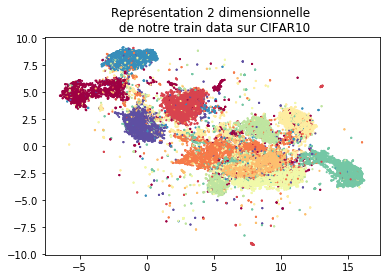

In [100]:
plt.scatter(train_embedding[:, 0], train_embedding[:, 1], c=labels_train, cmap='Spectral', s=1.3)
plt.title('Représentation 2 dimensionnelle \n de notre train data sur CIFAR10')
plt.show()

In [125]:
%%time

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf_svc = SVC(gamma=2, C=1)
clf_svc.fit(train_embedding, labels_train)
y_pred_svc = clf_svc.predict(test_embedding)
acc_svc = accuracy_score(labels_test, y_pred_svc)
print ('SVC accuracy: ',acc_svc)

SVC accuracy:  0.4145
Wall time: 40.3 s


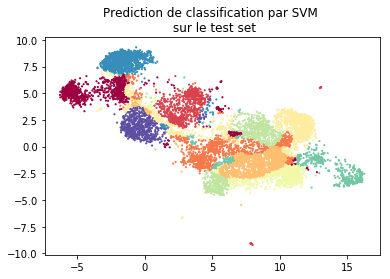

In [126]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_pred_svc, cmap='Spectral', s=1.3)
plt.title('Prediction de classification par SVM \n sur le test set')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 99.75it/s]


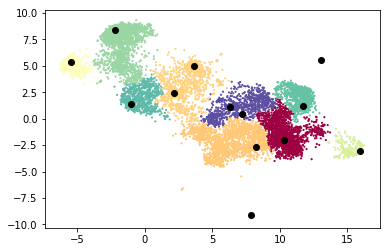

Wall time: 1min 26s


In [116]:
%%time

model = ToMATo(test_embedding, 118)
y_predict, centroids = model.clustering(6)
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_predict, cmap='Spectral', s=1.3)
plt.scatter(centroids[:,0], centroids[:,1], color='k')
plt.show()

### Essaie avec les images en niveau de gris et non en couleur

In [171]:
def transform_greyscale(data):
    
    data_greyscale = []
    
    for image in tqdm(data):
        
        im_rgb = np.reshape(image, (3,1024))
        r = im_rgb[0,:]
        g = im_rgb[1,:]
        b = im_rgb[2,:]
        data_greyscale.append(0.2989 * r + 0.5870 * g + 0.1140 * b)
    
    return(np.array(data_greyscale))

In [172]:
data_train_grey = transform_greyscale(data_train)
data_test_grey = transform_greyscale(data_test)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 55234.65it/s]


In [175]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data_train_grey)
X_train = scaler.transform(data_train_grey)
X_test = scaler.transform(data_test_grey)

In [176]:
%%time

import umap

mapper = umap.UMAP(n_components=2, random_state=42, metric='correlation').fit(X_train, labels_train)

Wall time: 2min 52s


In [177]:
%%time
test_embedding = mapper.transform(X_test)

Wall time: 26.7 s


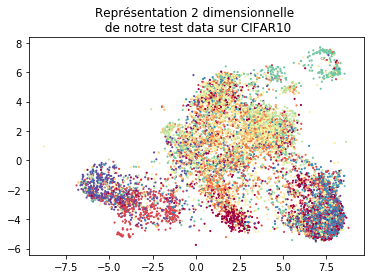

In [178]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=labels_test, cmap='Spectral', s=1.3)
plt.title('Représentation 2 dimensionnelle \n de notre test data sur CIFAR10')
plt.show()

In [179]:
%%time
train_embedding = mapper.transform(X_train)

Wall time: 512 ms


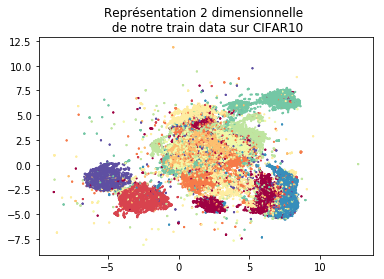

In [180]:
plt.scatter(train_embedding[:, 0], train_embedding[:, 1], c=labels_train, cmap='Spectral', s=1.3)
plt.title('Représentation 2 dimensionnelle \n de notre train data sur CIFAR10')
plt.show()

In [181]:
%%time

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf_svc = SVC(gamma=2, C=1)
clf_svc.fit(train_embedding, labels_train)
y_pred_svc = clf_svc.predict(test_embedding)
acc_svc = accuracy_score(labels_test, y_pred_svc)
print ('SVC accuracy: ',acc_svc)

SVC accuracy:  0.3442
Wall time: 56.7 s


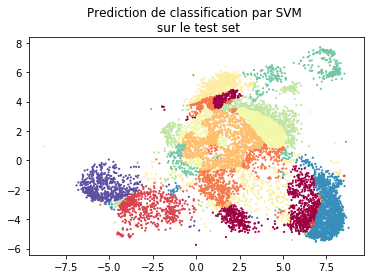

In [182]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_pred_svc, cmap='Spectral', s=1.3)
plt.title('Prediction de classification par SVM \n sur le test set')
plt.show()